<a href="https://colab.research.google.com/github/valdolab/DS_mAIstros/blob/main/Week5/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 5 - NLP

## Implementation of the model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

In [2]:
!pip install -q tf-models-official==2.7.0

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow import keras
import tensorflow_datasets as tfds

import os
import shutil

### load dataset and prepare to pre-process

In [6]:
#load model
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/EIT_W5/Models/binClass_89_GOUSE')

In [7]:
example = ["This is fucking good man!!!"]
example2 = ["I gonna kill you"]
example3 = ["I'm so fucking depressed"]
example5 = ["He should die!"]
example4 = ["Good morning guys, today is a beautiful day!"]

In [9]:
new_model.predict(example2)

array([[0.94578135]], dtype=float32)

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EIT_W5/labeled_data_nlp3.csv')
#drop the column index
#data = data.drop(['Indexs'], axis=1)
data

,String,y1,y2,y3
0,*screams in 25 different languages*,3,0,0
1,Families to sue over Legionnaires: More than 4...,4,4,0
2,Pandemonium In Aba As Woman Delivers Baby With...,4,4,0
3,My emotions are a train wreck. My body is a tr...,2,1,1
4,Alton brown just did a livestream and he burne...,4,5,0
...,...,...,...,...
1859,@Trollkrattos Juan Carlos Salvador The Secret ...,2,2,0
1860,@devon_breneman hopefully it doesn't electrocu...,4,2,0
1861,Businesses are deluged with invokces. Make you...,4,2,0
1862,#BREAKING411 4 police officers arrested for ab...,4,2,0


In [6]:
data.dtypes

String    object
y1         int64
y2         int64
y3         int64
dtype: object

4    1315
0     206
3     155
1     134
2      54
Name: y1, dtype: int64


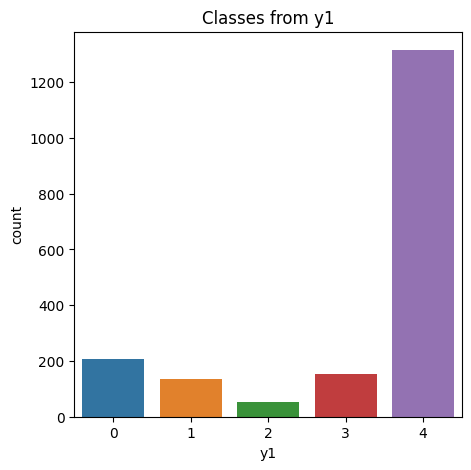

In [7]:
print(data.iloc[:,1].value_counts())

plt.figure(figsize=(5, 5))
sns.countplot(x=data["y1"])
plt.title('Classes from y1')
plt.show()

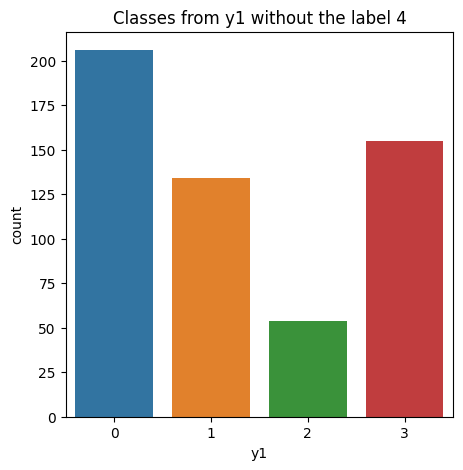

In [8]:
#we removed the label 4 for the y1, and then try to make the classification
data_t1 = data.drop(data[data["y1"]==4].index)

plt.figure(figsize=(5, 5))
sns.countplot(x=data_t1["y1"])
plt.title('Classes from y1 without the label 4')
plt.show()


2    600
5    401
4    326
1    205
3    186
0    146
Name: y2, dtype: int64


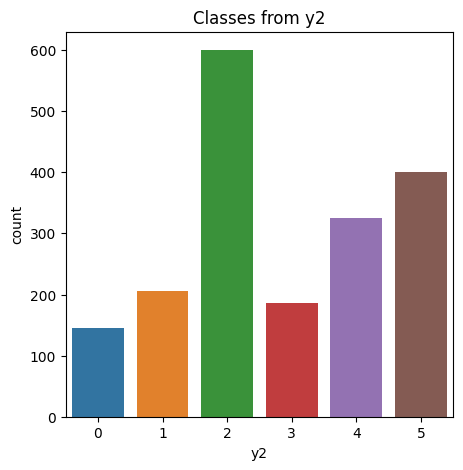

In [ ]:
print(data.iloc[:,2].value_counts())

plt.figure(figsize=(5, 5))
sns.countplot(x=data["y2"])
plt.title('Classes from y2')
plt.show()

In [ ]:
#just drop it all the label 2 (the rest)
# data_t2 = data.drop(data[data["y2"]==2].index)
# plt.figure(figsize=(5, 5))
# sns.countplot(x=data_t2["y2"])
# plt.title('Classes from y2')
# plt.show()

3    401
0    346
2    326
1    186
Name: y2, dtype: int64


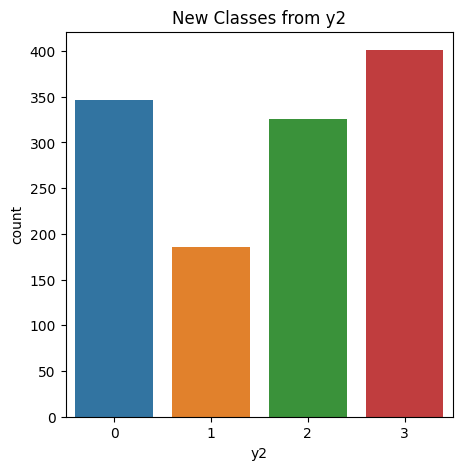

In [ ]:
class_2_multi = data.loc[data['y2'] == 2].sample(n=200,random_state=42)
class_0_multi = pd.concat([class_2_multi,data.loc[data['y2'] == 0]])
class_0_multi['y2'] = 0

new_multi = pd.concat([class_0_multi,data.loc[data['y2'] == 3],data.loc[data['y2'] == 4],data.loc[data['y2'] == 5]])

#all good, BUT we need to relabel the labels, in order to have something like: 0,1,2,3 intead of 0,3,4,5 <- this is a problem
#also to decode later the one-hot prediction
#So the relabels:
# 0 -> 0: Not a sentence and a few the rest class
# 3 -> 1: happy
# 4 -> 2: tragic
# 5 -> 3: opinions
new_multi.loc[new_multi['y2']==3,'y2'] = 1
new_multi.loc[new_multi['y2']==4,'y2'] = 2
new_multi.loc[new_multi['y2']==5,'y2'] = 3

print(new_multi.iloc[:,2].value_counts())

plt.figure(figsize=(5, 5))
sns.countplot(x=new_multi["y2"])
plt.title('New Classes from y2')
plt.show()

0    1659
1     205
Name: y3, dtype: int64


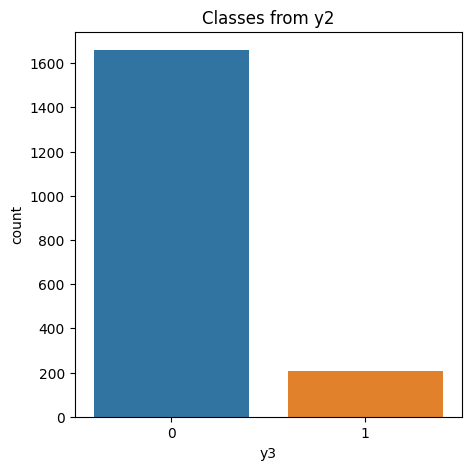

In [ ]:
print(data.iloc[:,3].value_counts())

plt.figure(figsize=(5, 5))
sns.countplot(x=data["y3"])
plt.title('Classes from y2')
plt.show()

### oversampling the offensive examples and undersampling the other examples

In [ ]:
#now oversampling
shuffled_df = data.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
class_1_temp = shuffled_df.loc[shuffled_df['y3'] == 1].copy()

class_1 = pd.concat([class_1_temp, shuffled_df.loc[shuffled_df['y3'] == 1]])

In [ ]:
#undersampling, choice 100 for each class (the others)
class_0 = shuffled_df.loc[shuffled_df['y2'] == 0].sample(n=100,random_state=42)
class_2 = shuffled_df.loc[shuffled_df['y2'] == 2].sample(n=100,random_state=42)
class_3 = shuffled_df.loc[shuffled_df['y2'] == 3].sample(n=100,random_state=42)
class_4 = shuffled_df.loc[shuffled_df['y2'] == 4].sample(n=100,random_state=42)
class_5 = shuffled_df.loc[shuffled_df['y2'] == 5].sample(n=100,random_state=42)

class_new = pd.concat([class_0, class_2 , class_3, class_4 , class_5 ])

In [ ]:
new_df =  pd.concat([class_new,class_1])

0    500
1    410
Name: y3, dtype: int64


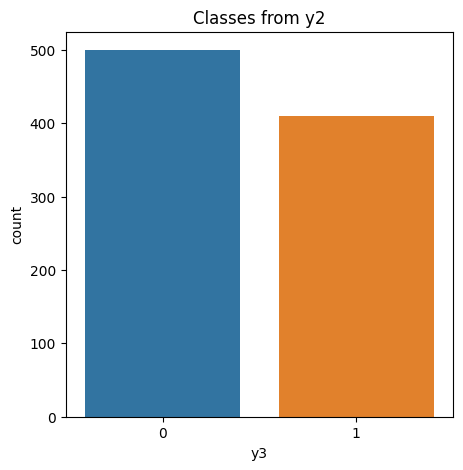

In [ ]:
print(new_df.iloc[:,3].value_counts())

plt.figure(figsize=(5, 5))
sns.countplot(x=new_df["y3"])
plt.title('Classes from y2')
plt.show()

### split the dataset

In [ ]:
# split the data into train and test set

# Shuffle dataframe using sample function
df = new_df.sample(frac=1)

# Select ratio
ratio = 0.90
 
total_rows = new_df.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
train = df[0:train_size]
test = df[train_size:]

In [ ]:
#also, we need to split into X and y
y_train = train.iloc[:,-1]
x_train = train.iloc[:,0]
y_test = test.iloc[:,-1]
x_test = test.iloc[:,0]

### Embedded text - Encoder

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

In [ ]:
model = hub.load(module_url)

In [ ]:
hub_layer = hub.KerasLayer(module_url,input_shape=[],dtype=tf.string,trainable = False)

#### Built net

In [ ]:
model = keras.Sequential()

In [ ]:
model.add(hub_layer)
#dropout layer here
model.add(keras.layers.Dropout(0.2))
#more neuros in the first layer, and a lit be with the next ones
model.add(keras.layers.Dense(150,activation='relu',kernel_regularizer='l2'))
model.add(keras.layers.Dense(100,activation='relu'))
#model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10,activation='relu'))
#binary = sigmoid, multi class = softmax to the last layer
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dropout_56 (Dropout)        (None, 512)               0         
                                                                 
 dense_75 (Dense)            (None, 150)               76950     
                                                                 
 dense_76 (Dense)            (None, 100)               15100     
                                                                 
 dropout_57 (Dropout)        (None, 100)               0         
                                                                 
 dense_77 (Dense)            (None, 10)                1010      
                                                                 
 dense_78 (Dense)            (None, 1)               

In [ ]:
model.compile(optimizer='Adam',loss = keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])

In [ ]:
history = model.fit(x=x_train, y=y_train,
                    epochs=18,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    batch_size=10)

Epoch 1/18
82/82 - 5s - loss: 0.1298 - accuracy: 0.9890 - val_loss: 0.6855 - val_accuracy: 0.8352 - 5s/epoch - 59ms/step
Epoch 2/18
82/82 - 1s - loss: 0.1215 - accuracy: 0.9829 - val_loss: 1.0585 - val_accuracy: 0.8022 - 1s/epoch - 16ms/step
Epoch 3/18
82/82 - 1s - loss: 0.1276 - accuracy: 0.9890 - val_loss: 0.7468 - val_accuracy: 0.8462 - 1s/epoch - 16ms/step
Epoch 4/18
82/82 - 1s - loss: 0.1268 - accuracy: 0.9841 - val_loss: 0.6184 - val_accuracy: 0.8571 - 770ms/epoch - 9ms/step
Epoch 5/18
82/82 - 1s - loss: 0.1410 - accuracy: 0.9817 - val_loss: 0.7960 - val_accuracy: 0.8022 - 669ms/epoch - 8ms/step
Epoch 6/18
82/82 - 1s - loss: 0.1510 - accuracy: 0.9792 - val_loss: 0.7196 - val_accuracy: 0.8352 - 673ms/epoch - 8ms/step
Epoch 7/18
82/82 - 1s - loss: 0.1315 - accuracy: 0.9805 - val_loss: 1.0316 - val_accuracy: 0.7692 - 681ms/epoch - 8ms/step
Epoch 8/18
82/82 - 1s - loss: 0.1583 - accuracy: 0.9841 - val_loss: 1.0886 - val_accuracy: 0.7582 - 644ms/epoch - 8ms/step
Epoch 9/18
82/82 - 1s 

### save the model 

In [ ]:
#the best model got a 0.89
dataset_name = 'binClass_Opt/89'
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/EIT_W5/Models/{}_GOUSE'.format(dataset_name.replace('/','_'))
print(saved_model_path)

#save the trained model
model.save(saved_model_path, include_optimizer=True)

/content/drive/MyDrive/Colab Notebooks/EIT_W5/Models/binClass_Opt_89_GOUSE


In [ ]:
#make a example of deploy using the saved model
reloaded_model = tf.saved_model.load("/content/drive/MyDrive/Colab Notebooks/EIT_W5/Models/binClass_89_GOUSE")

In [ ]:
example = ["This is fucking good man!!!"]
example2 = ["I gonna kill you"]
example3 = ["I'm so fucking depressed"]
example5 = ["He should die!"]
example4 = ["Good morning guys, today is a beautiful day!"]

In [ ]:
tf.sigmoid(reloaded_model(tf.constant(example5)))[0][0]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5968618]], dtype=float32)>

In [ ]:
model.predict(example5)

array([[0.39240617]], dtype=float32)

#### Model 2 Multi class

In [10]:
# split the data into train and test set

# Shuffle dataframe using sample function
#df = new_multi.sample(frac=1)
#df = data_t2.sample(frac=1)
df = data_t1.sample(frac=1)

# Select ratio
ratio = 0.80
 
total_rows = data_t1.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
train_2 = df[0:train_size]
test_2 = df[train_size:]

In [11]:
train_2

,String,y1,y2,y3
776,#Bestnaijamade: 16yr old PKK suicide bomber wh...,0,4,0
1116,SEISMIC AUDIO SA-15T SA15T Padded Black Speake...,0,0,0
641,OMG Horrible Accident Man Died in Wings of Air...,3,4,0
549,Did I drink too much? Am I losing touch? Did I...,1,3,0
383,HEALTH FACT: 75% of muscle mass is made up of ...,2,2,0
...,...,...,...,...
1370,@heebsterrr_ I remember the heat wave the year...,1,2,0
1463,@_AsianShawtyy ?????????? I'm sorry. But I'm out,3,2,0
671,@FEVWarrior -in the Vault that could take a lo...,0,0,0
87,@BrodyFrieling @hanna_brooksie photo bombed,0,0,0


In [13]:
#also, we need to split into X and y
y_train_2 = train_2.iloc[:,1]
x_train_2 = train_2.iloc[:,0]
y_test_2 = test_2.iloc[:,1]
x_test_2 = test_2.iloc[:,0]

y_train_2.unique()

array([0, 3, 1, 2])

In [15]:
#save the NO one-hot label test
NOH_y_test = y_test_2.to_numpy()

train_Y = pd.get_dummies(y_train_2)
test_Y = pd.get_dummies(y_test_2)
display(test_Y)
#convert to array
train_Y = train_Y.values
test_Y = test_Y.values
#test_Y

,0,1,2,3
1115,0,1,0,0
1713,0,0,0,1
703,1,0,0,0
292,0,1,0,0
977,0,0,1,0
...,...,...,...,...
247,0,1,0,0
786,1,0,0,0
1577,0,0,0,1
743,1,0,0,0


In [16]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
model = hub.load(module_url)
hub_layer = hub.KerasLayer(module_url,input_shape=[],dtype=tf.string,trainable = False)

In [23]:
model2 = keras.Sequential()

In [24]:
model2.add(hub_layer)
#dropout layer here
model2.add(keras.layers.Dropout(0.1))
#more neuros in the first layer, and a lit be with the next ones
model2.add(keras.layers.Dense(200,activation='relu'))
model2.add(keras.layers.Dropout(0.1))
model2.add(keras.layers.Dense(100,activation='relu'))
model2.add(keras.layers.Dropout(0.1))
model2.add(keras.layers.Dense(50,activation='relu'))
model2.add(keras.layers.Dropout(0.1))
model2.add(keras.layers.Dense(10,activation='relu'))
#binary = sigmoid, multi class = softmax to the last layer
#the last layer need to have the same neurons as classes
model2.add(keras.layers.Dense(4,activation='softmax'))

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               102600    
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 50)               

In [26]:
#model2.compile(optimizer='Adam',loss = "categorical_crossentropy", metrics = ['accuracy'])
model2.compile(optimizer='Adam',loss = keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [27]:
history = model2.fit(x=x_train_2, y=train_Y,
                    epochs=20,
                    verbose=2,
                    validation_data=(x_test_2, test_Y),
                    batch_size=10)

Epoch 1/20
44/44 - 5s - loss: 1.3335 - accuracy: 0.3667 - val_loss: 1.2993 - val_accuracy: 0.3636 - 5s/epoch - 114ms/step
Epoch 2/20
44/44 - 0s - loss: 1.2282 - accuracy: 0.3827 - val_loss: 1.2490 - val_accuracy: 0.4818 - 384ms/epoch - 9ms/step
Epoch 3/20
44/44 - 0s - loss: 1.0841 - accuracy: 0.5194 - val_loss: 1.2047 - val_accuracy: 0.5000 - 492ms/epoch - 11ms/step
Epoch 4/20
44/44 - 1s - loss: 0.8660 - accuracy: 0.6355 - val_loss: 1.2006 - val_accuracy: 0.5000 - 595ms/epoch - 14ms/step
Epoch 5/20
44/44 - 1s - loss: 0.6796 - accuracy: 0.7221 - val_loss: 1.2592 - val_accuracy: 0.4818 - 528ms/epoch - 12ms/step
Epoch 6/20
44/44 - 0s - loss: 0.5068 - accuracy: 0.7950 - val_loss: 1.4343 - val_accuracy: 0.5273 - 401ms/epoch - 9ms/step
Epoch 7/20
44/44 - 0s - loss: 0.3399 - accuracy: 0.8861 - val_loss: 1.6393 - val_accuracy: 0.5273 - 398ms/epoch - 9ms/step
Epoch 8/20
44/44 - 0s - loss: 0.1951 - accuracy: 0.9544 - val_loss: 1.9021 - val_accuracy: 0.5000 - 493ms/epoch - 11ms/step
Epoch 9/20
44

### Testing the model2

In [ ]:
y_hat2_ho = model2.predict(x_test_2)

In [ ]:
y_hat_pd = pd.DataFrame(y_hat2_ho)
y_hat_pd

,0,1,2,3
0,0.605809,0.217439,0.072423,0.104329
1,0.244060,0.054048,0.175472,0.526420
2,0.169413,0.018019,0.731596,0.080972
3,0.239005,0.338594,0.039879,0.382523
4,0.290087,0.381989,0.116609,0.211315
...,...,...,...,...
247,0.157572,0.180823,0.018646,0.642959
248,0.319662,0.246186,0.043442,0.390710
249,0.340195,0.403843,0.075093,0.180868
250,0.327740,0.038470,0.453076,0.180714


In [ ]:
y_hat2 = (np.argmax(y_hat2_ho, axis=1)) #.reshape(-1, 1)
y_hat2

array([0, 3, 2, 3, 1, 1, 3, 2, 3, 1, 3, 1, 2, 1, 0, 2, 3, 2, 3, 3, 1, 2,
       0, 3, 2, 1, 1, 0, 0, 3, 0, 1, 1, 1, 1, 3, 1, 3, 2, 3, 3, 0, 3, 1,
       0, 2, 3, 2, 2, 2, 1, 0, 1, 0, 3, 1, 2, 2, 1, 2, 2, 1, 2, 3, 3, 3,
       3, 3, 0, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 0, 3, 3, 3,
       3, 1, 2, 2, 0, 3, 0, 0, 3, 0, 1, 2, 0, 1, 3, 0, 0, 3, 2, 3, 1, 3,
       3, 0, 3, 3, 0, 0, 3, 1, 3, 3, 1, 1, 3, 3, 1, 2, 1, 2, 3, 3, 1, 2,
       0, 1, 0, 2, 3, 3, 1, 2, 2, 1, 3, 0, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 2, 3, 3, 2, 1, 2, 3, 0, 3, 2, 2, 2, 3, 3, 0, 0, 0, 3, 1, 1,
       1, 3, 2, 0, 0, 1, 3, 1, 3, 3, 0, 3, 2, 3, 1, 2, 1, 3, 3, 1, 1, 1,
       3, 2, 1, 1, 0, 0, 3, 2, 2, 2, 3, 2, 3, 2, 1, 0, 1, 0, 3, 3, 2, 0,
       2, 2, 3, 2, 3, 2, 1, 3, 2, 1, 0, 1, 1, 0, 0, 3, 1, 3, 1, 3, 1, 1,
       3, 3, 3, 2, 3, 3, 3, 1, 2, 3])

In [ ]:
NOH_y_test

array([0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 3, 3, 2, 1, 0, 0, 3, 2, 0, 0, 3, 2,
       0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 3, 0, 3, 2, 1, 1, 0, 0, 0,
       0, 3, 0, 0, 2, 2, 0, 2, 3, 0, 0, 3, 2, 2, 0, 2, 2, 0, 2, 3, 3, 2,
       3, 3, 0, 3, 3, 3, 0, 0, 3, 3, 0, 0, 3, 0, 1, 3, 1, 2, 2, 2, 3, 2,
       1, 1, 3, 2, 2, 3, 2, 0, 0, 0, 1, 2, 0, 3, 3, 0, 0, 1, 0, 3, 0, 3,
       3, 1, 0, 3, 2, 0, 3, 3, 2, 3, 1, 0, 3, 0, 0, 2, 3, 2, 2, 3, 1, 2,
       1, 0, 2, 2, 0, 3, 1, 2, 2, 2, 3, 0, 3, 0, 0, 1, 1, 3, 0, 1, 2, 0,
       1, 3, 3, 0, 0, 2, 1, 2, 0, 2, 3, 2, 0, 2, 3, 1, 2, 0, 0, 3, 0, 0,
       3, 0, 2, 2, 0, 3, 2, 0, 0, 3, 2, 2, 3, 2, 0, 2, 1, 3, 0, 3, 0, 3,
       3, 0, 0, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 1, 1, 3, 0, 0, 3, 3, 0, 0,
       0, 2, 0, 2, 3, 2, 1, 3, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 0, 1, 3, 1,
       2, 3, 2, 3, 1, 3, 2, 1, 2, 3])

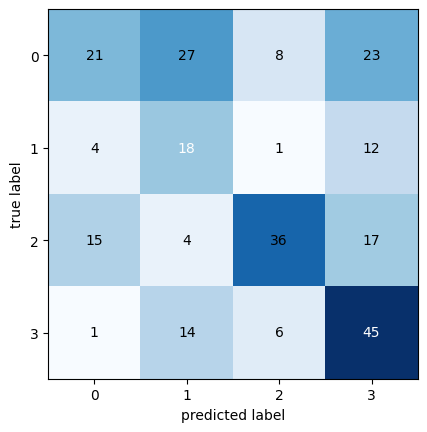

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

#NOH_y_test
#y_hat2

cm = confusion_matrix(y_target=NOH_y_test, 
                      y_predicted=y_hat2, 
                      binary=False)
#print(cm)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score

print(accuracy_score(NOH_y_test, y_hat2))
print(balanced_accuracy_score(NOH_y_test, y_hat2))

0.47619047619047616
0.49048167022850564


In [ ]:
#accuracy function
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

In [ ]:
#compute the accuracy per class
#NOH_y_test = y_true
#y_hat2     = y_pred

table_trues = pd.DataFrame([NOH_y_test,y_hat2]).T
table_trues_0 = table_trues.loc[table_trues.iloc[:,0] == 0]
table_trues_1 = table_trues.loc[table_trues.iloc[:,0] == 1]
table_trues_2 = table_trues.loc[table_trues.iloc[:,0] == 2]
table_trues_3 = table_trues.loc[table_trues.iloc[:,0] == 3]

c0 = table_trues_0.to_numpy()
c0_y_true = c0[:,0]
c0_y_hat = c0[:,1]
accu_c0 = accuracy(c0_y_true,c0_y_hat)

c1 = table_trues_1.to_numpy()
c1_y_true = c1[:,0]
c1_y_hat = c1[:,1]
accu_c1 = accuracy(c1_y_true,c1_y_hat)

c2 = table_trues_2.to_numpy()
c2_y_true = c2[:,0]
c2_y_hat = c2[:,1]
accu_c2 = accuracy(c2_y_true,c2_y_hat)

c3 = table_trues_3.to_numpy()
c3_y_true = c3[:,0]
c3_y_hat = c3[:,1]
accu_c3 = accuracy(c3_y_true,c3_y_hat)

print("Accuracy Class 0: ", accu_c0)
print("Accuracy Class 1: ", accu_c1)
print("Accuracy Class 2: ", accu_c2)
print("Accuracy Class 3: ", accu_c3)

Accuracy Class 0:  0.26582278481012656
Accuracy Class 1:  0.5142857142857142
Accuracy Class 2:  0.5
Accuracy Class 3:  0.6818181818181818


## Deploy of the model

In [ ]:
!pip install flask_restful

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 7.3 MB/s eta 0:00:00
